### Imports and function definitions

In [1]:
import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow_datasets as tfds
print('tfds version: ', tfds.__version__)
import pandas as pd
from tensorflow.keras.callbacks import TensorBoard
import datetime as datetime
from IPython import display
import seaborn as sns
import string

tensorflow version:  2.4.1
tfds version:  4.2.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Num GPUs Available:  2
GPUs:  2


# Load and Prepare the Dataset / Preprocessing Functions

In [3]:
#https://www.tensorflow.org/datasets/keras_example

(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    'celeb_a',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,)

def preprocess(data):
    """Normalizes images: `uint8` -> `float32`."""
    image = data['image']
    label = data['attributes']
    NUM_BOXES = 1
    boxes = [[.1,.1,.9,.9,]]
    box_indices = tf.zeros(shape=(NUM_BOXES,), dtype=tf.int32)
    #image = tf.image.resize(image[20:-20], [64, 64], antialias=True)
    image = tf.image.crop_and_resize(tf.expand_dims(image, axis=0), crop_size=[64, 64], boxes=boxes, box_indices=box_indices)
    image = tf.cast(image, tf.float32) / 255. # normalise images to between 0 and 1
    image = image[0]
    return image, label

ds_train = ds_train_raw.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [4]:
# for data in ds_train:
#     for i in range(10):
#         plt.imshow(data[0][i])
#         plt.show()
#     break

In [5]:
# Get attributes list
for images, attributes in ds_train:
    break
    
# Checks
print(images.shape)
print(images[0].shape)
print(attributes.keys())
print(images.numpy().max())
print(images.numpy().min())

(128, 64, 64, 3)
(64, 64, 3)
dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])
1.0
0.0


# Create the models

Adapated from https://www.tensorflow.org/tutorials/generative/dcgan which uses MNIST to create a non-conditional GAN

### Generator

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x1. Notice the tf.keras.layers.LeakyReLU activation for each layer, except the output layer which uses tanh.

In [6]:
# The generator
def make_generator_model():
    
    model = tf.keras.Sequential(name='Generator')
    
    # Densly connection NN layer of 4*4*1024 (16,384) neurons. This is taking in the input and multiplying with the weights
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(40+24,))) 
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 4 x 4 image with 1024 features.
    model.add(layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)  # Note: None is the batch size

    # Compress channels/features to 512
    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # channels=128, filter size=5*5
    assert model.output_shape == (None, 8, 8, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Upsampling block
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Upsampling block
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Output layer - Activation of sigmoid is used to squash values between 0 and 1 in line with image values after preprocessing
    model.add(layers.Conv2DTranspose(3, (5, 5), activation='sigmoid', strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 3)

    return model

### Discriminator

The discriminator is a CNN-based image classifier.

In [7]:
def make_discriminator_model():
    
    # label input
    attribute_vector = layers.Input(shape=(40+24))
    input_image = layers.Input(shape=(64,64,3))
    
    conv_model = tf.keras.Sequential(name='Discriminator_conv_model')
    
    # gan hacks - add noise to help generate a variety of images
    conv_model.add(layers.GaussianNoise(stddev=0.1))
    
    # downsample - increase filters as it progresses through the model
    conv_model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    conv_model.add(layers.BatchNormalization())
    conv_model.add(layers.LeakyReLU())
    #assert conv_model.output_shape == (None, 32, 32, 64)
    
    #downsample
    conv_model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    conv_model.add(layers.BatchNormalization())
    conv_model.add(layers.LeakyReLU())
    
    #downsample
    conv_model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    conv_model.add(layers.LeakyReLU())
    conv_model.add(layers.Dropout(0.3))
    
    # classifier - flatten to 1D array
    conv_model.add(layers.Flatten())
    
    # Push image through model above, shape=[batch,dimensions(128*8*8)]
    img_feature_vec = conv_model(input_image)
    
    # concatenate layers - the image vector + the attribute labels, shape=[batch, dimensions(128*8*8+40)]
    merge = layers.Concatenate()([img_feature_vec, attribute_vector])
    
    # Gan Hacks - deeper model
    dense_model = tf.keras.Sequential(name='Discriminator_deep')
    dense_model.add(layers.Dense(128))
    #dense_model.add(layers.Dense(256))
    dense_model.add(layers.LeakyReLU())
    dense_model.add(layers.Dropout(0.3))
    dense_model.add(layers.Dense(1))

    # Push image + attributes through model and make a prediction
    output = dense_model(merge)
    
    # Create new model here with correct shapes which need to be defined as inputs
    model = tf.keras.Model(inputs=[input_image, attribute_vector], outputs=output, name='Discriminator')

    return model

In [8]:
# Create Models
# Classify the generated images as real or fake using the discriminator.
# Model is trained to output positive values for real images and negative values for fake images

generator = make_generator_model()
discriminator = make_discriminator_model()

# Define the loss and optimisers

In [9]:
# This method returns a helper function to compute cross entropy loss
# The discriminator has binary input (fake or real data) so a binary loss function is used
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

Quantifies how well the discriminator is able to distinguish real images from fakes.  

It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

Quantifies how well it was able to trick the discriminator.  

If the generator is performng well, the discriminator will classify the fake images as real (or 1). This function compares the discriminators decisions on the generated images to an array of 1s

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimisers

Two different optimisers required since the two networks are trained separately

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Save checkpoints

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training Loop

The training loop begins with generator receiving attributes + noise as input. This is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [14]:
def convert_attrbutes_to_vec_tf(attributes):
    
    # Convert to tensor - transpose as tensorflow looks at batch first
    batch_attributes_as_bool_tensor = tf.transpose(tf.stack(list(attributes.values())))
    
    # Convert from boolean to float - true = 1, false = -1
    batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)

    # Create Noise
    input_noise = tf.random.normal([128, 24])
    
    # Cooncat noise to attributes
    attributes_input = tf.concat([batch_attributes_as_float_tensor, input_noise], axis=-1)
    
    return attributes_input

In [15]:
@tf.function #execute code in graph mode for efficiency
def train_step(images, attributes):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # Generate noise to pass to generator
        attribute_input = convert_attrbutes_to_vec_tf(attributes)

        # Make generated image and pass to discriminator for prediction
        generated_images = generator(attribute_input, training=True)
        real_output = discriminator((images, attribute_input), training=True)
        fake_output = discriminator((generated_images, attribute_input), training=True)

        # Calculate loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # Keep an eye on what discriminator is deciding (visualised in tensorboard)
        mean_real_output = tf.math.reduce_mean(tf.nn.sigmoid(real_output))
        mean_fake_output = tf.math.reduce_mean(tf.nn.sigmoid(fake_output))

    # Calculate gradients - the derivative of the loss with respect to the model weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # Tweak model weights based on optimiser calculations
    # zip function is used to align the array of 128 (or other batch size) gradients with the 128 trainable variables that the gradients will update
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return attribute_input, gen_loss, disc_loss, mean_real_output, mean_fake_output
    
def train(dataset, epochs, num_examples_to_generate):
    
    # tensorboard callback
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_dir='tensorboard_log/' + current_time
    summary_writer = tf.summary.create_file_writer(log_dir)
        
    for epoch in range(epochs):
        start = time.time()

        for image_batch, attribute_batch in dataset:
            attribute_input, gen_loss, disc_loss, mean_real_output, mean_fake_output = train_step(image_batch, attribute_batch)

        # Produce images
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, attribute_input[:num_examples_to_generate])
        
        # save data for tensorboard
        with summary_writer.as_default():
            tf.summary.scalar('gen_loss', gen_loss, step=epoch)
            tf.summary.scalar('disc_loss', disc_loss, step=epoch)
            tf.summary.scalar('mean_real_output', mean_real_output, step=epoch)
            tf.summary.scalar('mean_fake_output', mean_fake_output, step=epoch)

        # Save the model every 50 epochs
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
# Generate and save images
def generate_and_save_images(model, epoch, test_input):
    # `training` is set to False. This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    image_folder = 'generated_images/'
    image_filepath = image_folder + 'image_at_epoch_{:04d}.png'
    plt.savefig(image_filepath.format(epoch))
    plt.show()


# Train the model

Generator and discriminator are trained simultaneously.  

It is important that the generator and discriminator do not overpower each other (i.e. they train at a similar rate)

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images look increasingly real.

In [16]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [18]:
assert False

AssertionError: 

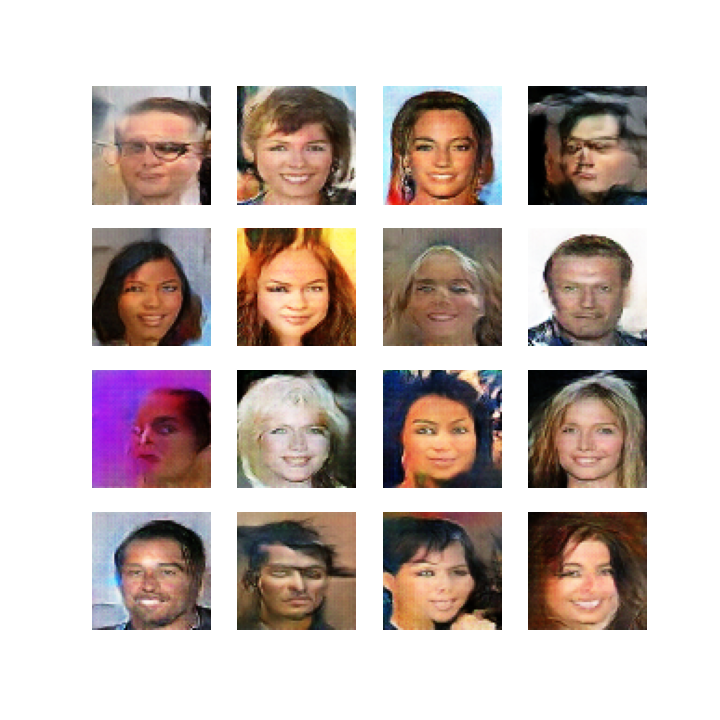

In [17]:
# Images from epoch
def display_image(epoch_no):
    return PIL.Image.open('./generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(100)

# Generate Images

## Functions

### Attribute Synonym Mapping

In order to process text to generate an image, we need to search the text for attributes. 

The Celeb_A dataset has 40 attributes which we have mapped to additional synonyms.

We have then created a function to take the text and search for attributes by first looking for trigrams and iterating down to unigrams

In [37]:
# Dictionary of synonyms aligned with attributes per Celeb_A dataset

dict_attribute_to_synonym = {
    'Attractive': ['attractive', 'beautiful', 'alluring', 'glamorous', 'lovely', 'inviting', 'fair', 'enticing', 
                   'interesting', 'charming', 'pleasant', 'good-looking', 'tempting', 'gorgeous', 'pretty',
                   'engaging', 'pleasing', 'handsome', 'adorable', 'agreeable', 'comely', 'enchanting'],
    'Bags_Under_Eyes': ['bags under eyes', 'dark circles under eyes'],
    'Bald': ['bald', 'hairless', 'baldheaded', 'no hair', 'little hair', 'abrupt', 'shaven', 'depilated', 'plain', 
             'direct', 'stark', 'bald headed', 'glabrous', 'austere', 'downright', 'forthright', 'outright', 'head shaved'],
    'Big_Lips': ['big lips', 'pouty lips', 'round lips', 'plump lips', 'puffy lips', 'full lips', 
                 'fat lips', 'big mouth', 'massive mouth', 'thick lips', 'fleshy lips', 'puffy lips', 'big-lipped'],
    'Bangs': ['bangs', 'fringe'],
    'Big_Nose': ['big nose', 'big-nosed', 'large nose', 'schnoz', 'huge nose', 'fleshy hooked nose'],
    'Black_Hair': ['black hair', 'jet black hair', 'inky hair', 'pitch-black hair', 'coal-black hair', 'inky-black hair', 'jet-black hair', 
                   'raven hair'],
    'Blond_Hair': ['blond hair', 'fair hair', 'blonde hair', 'yellow hair', 'golden hair', 'light hair', 'sandy hair', 
                   'bottle blond hair', 'honey blond hair', 'golden-yellow hair', 'platinum blond hair', 
                   'platinum hair', 'sandy blond hair'],
    'Brown_Hair': ['brown hair', 'chestnut hair', 'dark brown hair', 'brownish hair', 'light brown hair', 
                   'caramel brown hair', 'dark hair', 'walnut brown hair', 'brown-haired hair', 
                   'chocolate brown hair', 'chocolate hair', 'chocolate coloured hair', 'cinnamon brown hair', 
                   'hazel hair', 'maple brown hair'],
    'Bushy_Eyebrows': ['bushy eyebrows', 'thick eyebrows', 'hairy eyebrows', 'heavy eyebrows', 'intense eyebrows', 
                       'massive eyebrows'],
    'Chubby':['chubby', 'plump', 'tubby', 'pudgy', 'rotund', 'overweight', 'chunky', 'portly', 'stout', 'fleshy', 'corpulent', 
              'fat', 'dumpy', 'obese', 'beefy', 'heavy', 'meaty', 'gross', 'bulky', 'fat man', 'full-figured', 'hefty', 
              'thick', 'sturdy'],
    'Double_Chin': ['double chin', 'double-chinned', 'double chinned'],
    'Eyeglasses': ['eyeglasses', 'glasses', 'spectacles'],
    'Goatee': ['goatee', 'anchor beard', 'balbo beard', 'facial hair'],
    'Gray_Hair': ['gray hair', 'grey hair', 'grey haired', 'white hair', 'salt and pepper hair', 'salt-and-pepper', 
                  'grizzled', 'white haired', 'angling', 'gray haired', 'gray-haired', 'silver hair', 'greying hair', 
                  'white-haired'],
    'Heavy_Makeup': ['heavy makeup', 'thick makeup', 'full makeup'],
    'High_Cheekbones': ['high cheekbones', 'prominent cheekbones'],
    'Male': ['male', 'man', 'he', 'guy','gentleman', 'dude', 'mr', 'his'],
    'Mouth_Slightly_Open': ['open mouth'],
    'Mustache': ['mustache', 'whisker', 'mustachio'],
    'Narrow_Eyes': ['narrow eyes', 'little eyes', 'slender eyes', 'small eyes', 'blinkered eyes', 'skinny eyes'],
    'Oval_Face': ['oval face', 'spherical face', 'oval smile', 'round look', 'round face'],
    'No_Beard': ['no beard', 'beardless', 'clean shaven', 'shaved'],
    'Pale_Skin': ['pale skin', 'white skin', 'pale', 'pallor', 'blonde skin', 'fair skin', 'ghost like', 'ghostly skin', 'ghostly complextion', 'ivory'],
    'Pointy_Nose': ['pointy nose', 'pointed nose', 'pointy root', 'sharp nose', 'keen nose'],
    'Receding_Hairline': ['receding hairline', 'getting bald', 'going bald', 'little hair', 'alopecia', 'losing hair', 'balding'],
    'Rosy_Cheeks': ['rosy cheeks', 'red cheek', 'flushed face', 'pink face', 'bright cheek'],
    'Sideburns': ['sideburns', 'shiskers', 'side whiskers', 'mutton chop'],
    'Smiling': ['smiling', 'smile', 'grin', 'happy', 'grinning', 'cheerful', 'smiled'],
    'Straight_Hair':['straight hair', 'sleek hair', 'straight hair style'],
    'Wavy_Hair': ['wavy hair', 'curly hair', 'curls', 'curled hair', 'wavy', 'curling', 'curly'],
    'Earrings': ['earrings', 'earing', 'studs'],
    'Hat': ['hat', 'bonnet', 'cap', 'helmet', 'hood', 'beret'],
    'Lipstick': ['lipstick', 'lip rouge', 'lip gloss', 'makeup', 'chapstick', 'red lips'],
    'Necklace': ['necklace', 'pendant', 'choker', 'necklet', 'bead', 'pearls'],
    'Necktie': ['necktie', 'tie', 'cravat', 'bow tie', 'black tie'],
    'Young': ['young', 'youth', 'youthful', 'junior', 'youger', 'children']
}

# Create reversed dictionary of synonym to attribute
dict_synonym_to_attribute = {}
for key, value in dict_attribute_to_synonym.items():
    for sub_value in value:
        dict_synonym_to_attribute[sub_value] = key

In [47]:
#dict_synonym_to_attribute
dict_synonym_to_attribute['curly']

'Wavy_Hair'

### Convert text to attributes

Process
- Clean string: remove punctuation, split on space to list, convert to lower case
- Compare all 3 word length sequential word combinations against synonym to attributes dictionary, delete words from list if found
- Continue for 2 and 1 word length combination
- Final output is a list of attributes found in text that align with attributes included in the dataset

In [39]:
# Function to process text to attributes

def get_attributes_from_text(text):
    """
    process text to extract attributes matched to celeb_a dataset
    input: string
    output: list of attributes as strings
    """
    text = text.translate(str.maketrans("","", string.punctuation))
    text = text.split(' ')
    text = [word.lower() for word in text]
    #print(text)
    attr_list = []
    
    # Check for trigrams and delete from description if present
    for i in reversed(range(len(text) - 2)):
        try:
            attr_list.append(dict_synonym_to_attribute[' '.join([text[i], text[i+1], text[i+2]])])
            del text[i]
            del text[i]
            del text[i]
        except:
            pass
    
    # Check for bigrams and delete from description if present
    for i in reversed(range(len(text) - 1)):
        try:
            attr_list.append(dict_synonym_to_attribute[' '.join([text[i], text[i+1]])])
            del text[i]
            del text[i]
        except:
            pass

    # Check for unigrams and delete from description if present
    for i in reversed(range(len(text))):
        try:
            attr_list.append(dict_synonym_to_attribute[text[i]])
            del text[i]
        except:
            pass
        
    attr_list = list(set(attr_list))
    print(attr_list)
        
    return attr_list

### Convert attributes to image vector

The attributes processed from text must be converted to the appropriate format required by the generator

Process
- Create a base dictionary containing False values against all attributes
- Using the attributes list processed from the text, loop through the base dictionary, setting an attribute to True when found.
- Convert these boolean values to a vector/tensor that can be put into the generator
- A further function has been created to enable this to be done for multiple examples
- A noise parameter can been set to T/F to allow for a greater variation of images per combination of attributes or just the mean image

In [40]:
attributes.keys()

dict_keys(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young'])

In [41]:
# Create dictionary of attributes to bool value
def create_attribute_base_dict():
    """
    dictionary mapping False to each attribute
    output: dict of attribute:bool
    """
    attribute_base_dict = {}

    for idx, attribute in enumerate(attributes.keys()):
        attribute_base_dict[attribute] = False
        
    return attribute_base_dict

attribute_base_dict = create_attribute_base_dict()

In [42]:
def attributes_bool_ordered(attribute_base_dict, attribute_to_find):
    """
    order boolean values in same order as received by model
    output: list of boolean values
    """
    attribute_to_find = list(attribute_to_find)
    
    attribute_values = []
    for attribute in sorted(attribute_base_dict.keys()):
        attribute_values.append(True if attribute in attribute_to_find else False)
        # No Beard is a negative attribute, reverse decision from above
        if attribute == 'No_Beard':
            attribute_values[-1] = not attribute_values[-1]
        
    return attribute_values

def attributes_multiple_list(attribute_to_find):
    """
    create list of lists of attributes in ordered bool form
    output: list of lists of boolean values
    """
    if any(isinstance(item, list) for item in attribute_to_find):
        attribute_values = []
        for attribute_list in attribute_to_find:
            attribute_values.append(attributes_bool_ordered(attribute_base_dict, attribute_list))
        
    else:
        attribute_values = attributes_bool_ordered(attribute_base_dict, attribute_to_find)
    return attribute_values

def convert_attrbutes_to_vec(attributes, noise=True):
    """
    prepare attributes for image generation
    input: list of ordered boolean values
    output: tensor of shape (num_images, 40)
    """
    # Order attributes
    attributes = attributes_multiple_list(attributes)
    
    # Convert to tensor
    batch_attributes_as_bool_tensor = tf.stack(list(attributes))
    if len(batch_attributes_as_bool_tensor.shape) == 1:
        num_images = 1
    else:
        num_images = batch_attributes_as_bool_tensor.shape[0]
    batch_attributes_as_bool_tensor = tf.reshape(batch_attributes_as_bool_tensor, [num_images,40])
    
    # Convert from boolean to float
    batch_attributes_as_float_tensor = tf.where(batch_attributes_as_bool_tensor, 1.,-1.)
    
    if noise:
        input_noise = tf.random.normal([num_images, 24])
    else:
        input_noise = tf.zeros([num_images, 24])
        
    attributes_input = tf.concat([batch_attributes_as_float_tensor, input_noise], axis=-1)
    
    return attributes_input

# Wrapper function for text to attributes
def convert_text_to_vector(text, noise=True):
    attributes_list = get_attributes_from_text(text)
    attributes = convert_attrbutes_to_vec(attributes_list, noise)
    return attributes

### Plot images

In [43]:
def plot_images(attributes_plot, cols=4):
    
    #attributes_plot = convert_attrbutes_to_vec(attributes_matrix, noise)
    generated_image = generator(attributes_plot, training=False)

    num_images = generated_image.shape[0]
    cols = cols
    rows = int(np.ceil(num_images / cols))

    fig = plt.figure(figsize=(cols*2, rows*2))

    for i in range(num_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(generated_image[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Generate Images

### Matrix of Images - No Noise, Comparison of attributes

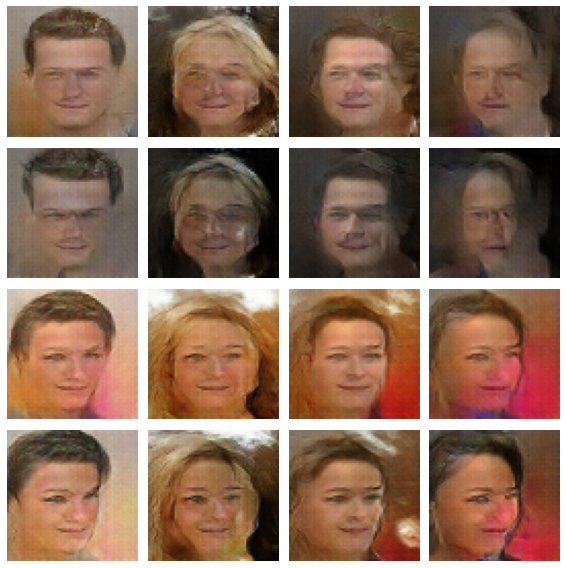

In [44]:
attributes_matrix = [['Male', 'Attractive', 'Smiling'],          ['Male', 'Blond_Hair', 'Smiling'],          ['Male', 'Brown_Hair', 'Smiling'],          ['Male', 'Wearing_Lipstick', 'Smiling'],
                     ['Male', 'Attractive',  'Smiling', 'Young'], ['Male', 'Blond_Hair',  'Smiling', 'Young'], ['Male', 'Brown_Hair',  'Smiling', 'Young'], ['Male', 'Wearing_Lipstick',  'Smiling', 'Young'],
                     ['Attractive',  'Smiling'],                  ['Blond_Hair',  'Smiling'],                  ['Brown_Hair',  'Smiling'],                  ['Wearing_Lipstick',  'Smiling'],
                     ['Attractive', 'Young',  'Smiling'],         ['Blond_Hair', 'Young',  'Smiling'],         ['Brown_Hair', 'Young',  'Smiling'],         ['Wearing_Lipstick', 'Young',  'Smiling']]

attributes_plot = convert_attrbutes_to_vec(attributes_matrix, noise=False)
plot_images(attributes_plot)

### Matrix of Images - Noise, Show Variety

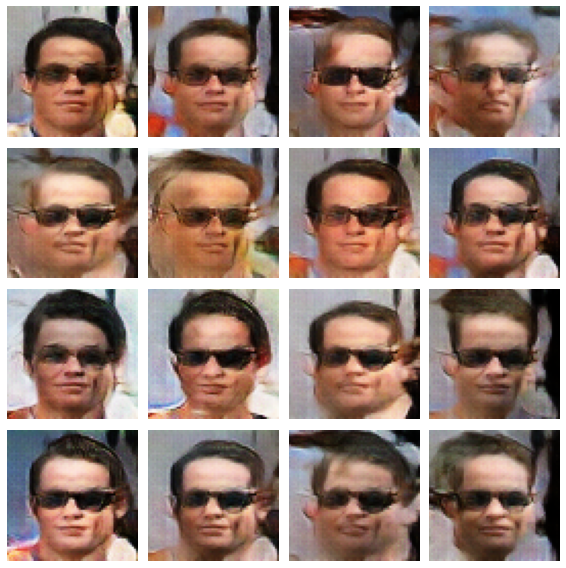

In [45]:
### Random faces able to be generated by adding noise

Attribute_1 = 'Eyeglasses'
Attribute_2 = 'Male'
Attribute_3 = 'Young'
Attribute_4 = 'Brown_Hair'
Attribute_5 = 'Smiling'
Attribute_6 = 'Oval_Face'

attributes_matrix = []
for i in range(16):
    attributes_matrix.append([Attribute_1, Attribute_2, Attribute_3, Attribute_4, Attribute_5, Attribute_6])  
    
attributes_plot = convert_attrbutes_to_vec(attributes_matrix, noise=True)

plot_images(attributes_plot)

### Images from book descriptions

['Pale_Skin', 'Lipstick', 'Wavy_Hair', 'Attractive', 'Smiling']
['Pale_Skin', 'Lipstick', 'Wavy_Hair', 'Attractive', 'Smiling']
['Pale_Skin', 'Lipstick', 'Wavy_Hair', 'Attractive', 'Smiling']
['Lipstick', 'Wavy_Hair', 'Oval_Face', 'Attractive', 'Smiling']
['Lipstick', 'Wavy_Hair', 'Oval_Face', 'Attractive', 'Smiling']
['Lipstick', 'Wavy_Hair', 'Oval_Face', 'Attractive', 'Smiling']
['Chubby', 'Black_Hair', 'Big_Nose', 'Male', 'Wavy_Hair']
['Chubby', 'Black_Hair', 'Big_Nose', 'Male', 'Wavy_Hair']
['Chubby', 'Black_Hair', 'Big_Nose', 'Male', 'Wavy_Hair']
['Young', 'Male', 'Black_Hair', 'Eyeglasses']
['Young', 'Male', 'Black_Hair', 'Eyeglasses']
['Young', 'Male', 'Black_Hair', 'Eyeglasses']


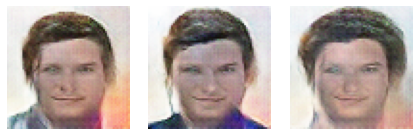

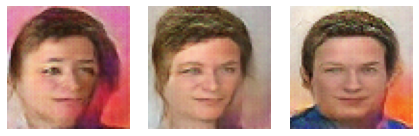

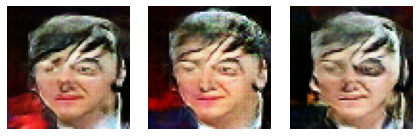

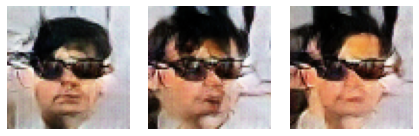

In [54]:
book_text_1 = 'It was a strikingly beautiful woman, with black curling hair, with full shoulder and bosom that seemed carved out of old ivory, with a pensive smile on the red lips, triumphantly and softly she looked at him with eyes that baffled him.'
book_text_2 = 'Elayne is described as exceedingly beautiful, with blue eyes like sapphires and red-gold, curly hair. With a smooth-skinned, perfectly oval face, Elayne can charm many with her pretty, dimpled smile with full red lips. She stands around one span, six inches tall with long supple limbs.'
book_text_3 = 'Mr. Kaleda was short and of a sturdy build, clean-shaven and dark skinned, with a fleshy, hooked nose and very large lustrous and liquid eyes. His long black hair was sleek and curly.'
#book_text_4 = 'Tywin is a tall, slender, broad-shouldered man in his fifties. His arms are thin but muscled. Tywin has kept his head shaved, but he grows out bushy golden side whiskers. Tywin has pale green eyes flecked with gold'
book_text_4 = 'Throughout the series, Harry is described as having his fathers perpetually untidy black hair, his mothers bright green eyes, and a lightning bolt-shaped scar on his forehead. He is further described as "small and skinny for his age" with "a thin face" and "knobbly knees", and he wears Windsor glasses. Young'

book_text_11 = convert_text_to_vector(book_text_1)
book_text_12 = convert_text_to_vector(book_text_1)
book_text_13 = convert_text_to_vector(book_text_1)
book_text_21 = convert_text_to_vector(book_text_2)
book_text_22 = convert_text_to_vector(book_text_2)
book_text_23 = convert_text_to_vector(book_text_2)
book_text_31 = convert_text_to_vector(book_text_3)
book_text_32 = convert_text_to_vector(book_text_3)
book_text_33 = convert_text_to_vector(book_text_3)
book_text_41 = convert_text_to_vector(book_text_4)
book_text_42 = convert_text_to_vector(book_text_4)
book_text_43 = convert_text_to_vector(book_text_4)

plot_images(tf.concat([book_text_11, book_text_12, book_text_13], axis=0))
plot_images(tf.concat([book_text_21, book_text_22, book_text_23], axis=0))
plot_images(tf.concat([book_text_31, book_text_32, book_text_33], axis=0))
plot_images(tf.concat([book_text_41, book_text_42, book_text_43], axis=0))

# Distribution of Attributes

In [ ]:
attributes_distribution = []

for images, attributes in ds_train:
    attributes_distribution.append(attributes)

In [ ]:
df = pd.DataFrame(columns = attributes.keys())

for batch in attributes_distribution:
    df_temp = pd.DataFrame(batch)
    df = df.append(df_temp)
    
print(len(df))

In [ ]:
df_count = pd.DataFrame(df.sum()).reset_index()
df_count.columns = ['Attribute', 'Count']
#df_count

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x='Attribute', y='Count', data=df_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
None

# Tensorboard Logs

In [46]:
import tensorboard as tb

In [105]:
experiment_id = "rXzzm6yoQy2JhM5cqpKYgQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()
runs = ['20210510-100715', '20210511-082653', '20210512-093941']
df = df[df['run'].isin(runs)]
rename_runs = {'20210510-100715': 'run_1', '20210511-082653': 'run_2', '20210512-093941': 'run_3'}
df = df.replace({"run": rename_runs})
rename_tag = {'disc_loss': 'Discriminator', 'gen_loss': 'Generator'}
df = df.replace({"tag": rename_tag})
df.columns = ['run', 'tag', 'Epoch', 'Value']

In [107]:
mask_2 = df['run'] == 'run_2'
df.loc[mask_2, 'Epoch'] = df.loc[mask_2, 'Epoch'] + 100
mask_3 = df['run'] == 'run_3'
df.loc[mask_3, 'Epoch'] = df.loc[mask_3, 'Epoch'] + 200

In [108]:
df#[df['run'] == 'run_2']

,run,tag,Epoch,Value
7544,run_1,Discriminator,0,0.254207
7545,run_1,Discriminator,1,0.220602
7546,run_1,Discriminator,2,0.558962
7547,run_1,Discriminator,3,0.393828
7548,run_1,Discriminator,4,0.351465
...,...,...,...,...
8739,run_3,mean_real_output,295,0.703438
8740,run_3,mean_real_output,296,0.759603
8741,run_3,mean_real_output,297,0.605781
8742,run_3,mean_real_output,298,0.634305


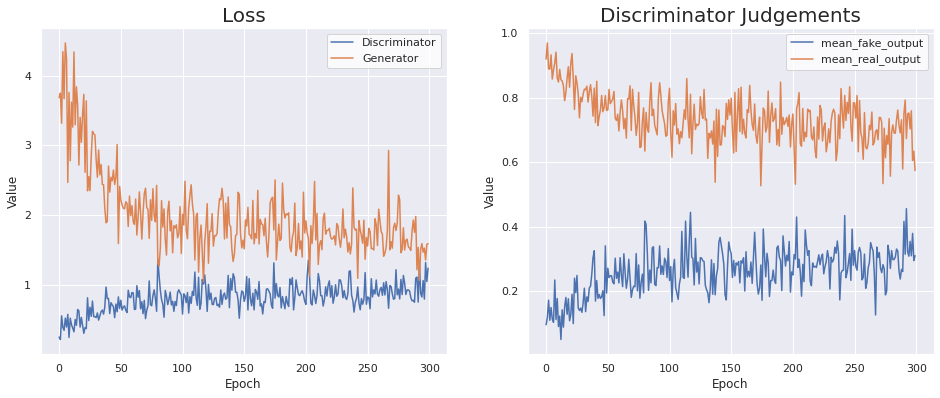

In [134]:
df_loss = df[df['tag'].isin(["Discriminator", "Generator"])]
df_disc = df[df['tag'].isin(["mean_real_output", "mean_fake_output"])]

sns.set()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))

sns.lineplot(data=df_loss, x="Epoch", y="Value", ax=ax1, hue="tag").set_title("Loss", fontsize=20)
ax1.get_legend().set_title(None)
ax1.legend(facecolor='white')
sns.lineplot(data=df_disc, x="Epoch", y="Value", ax=ax2, hue="tag").set_title("Discriminator Judgements", fontsize=20)
ax2.get_legend().set_title(None)
ax2.legend(facecolor='white')
None

# Other

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('./generated_images/image_at_epoch_{:04d}.png'.format(epoch_no))

display_image(50)

In [ ]:
generator.summary()

In [ ]:
discriminator.summary()

# References

- Dataset - https://www.tensorflow.org/datasets/catalog/celeb_a
- Model design - https://www.tensorflow.org/tutorials/generative/dcgan
- Model design - https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/
- Model design - Conditional Gan - https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
- Model design - https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
- Gan Hacks - Improving Gan Performance - https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/
- Adding noise - https://machinelearningmastery.com/how-to-improve-deep-learning-model-robustness-by-adding-noise/